This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [25]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-28 07:06:40--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.163.96, 52.216.51.200, 52.216.218.40, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.163.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  5.23MB/s    in 2.5s    

2022-11-28 07:06:43 (5.23 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [26]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [27]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

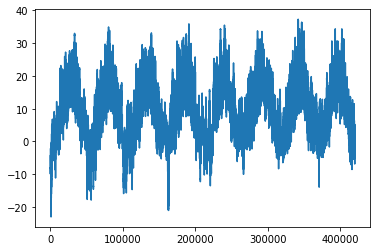

In [28]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

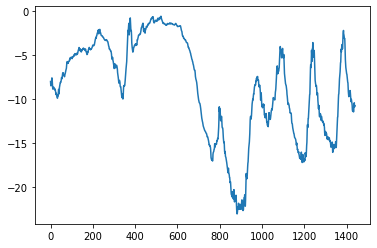

In [29]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [30]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [31]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [32]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [33]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [34]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [35]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 50ms/step - loss: 12.4551 - mae: 2.7388 - val_loss: 10.2287 - val_mae: 2.5110
Epoch 2/10
819/819 [==============================] - 41s 49ms/step - loss: 8.9994 - mae: 2.3616 - val_loss: 10.2608 - val_mae: 2.5191
Epoch 3/10
819/819 [==============================] - 41s 49ms/step - loss: 8.2757 - mae: 2.2649 - val_loss: 10.7212 - val_mae: 2.5768
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 7.8033 - mae: 2.2026 - val_loss: 12.3622 - val_mae: 2.7769
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 7.4795 - mae: 2.1587 - val_loss: 10.6099 - val_mae: 2.5642
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 7.2548 - mae: 2.1268 - val_loss: 11.2325 - val_mae: 2.6482
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 7.0631 - mae: 2.0998 - val_loss: 10.9848 - val_mae: 2.6042
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

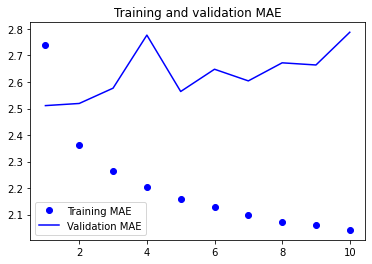

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 40s 48ms/step - loss: 23.4333 - mae: 3.7842 - val_loss: 21.7954 - val_mae: 3.7413
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 15.4396 - mae: 3.1266 - val_loss: 19.3496 - val_mae: 3.5145
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 14.0162 - mae: 2.9711 - val_loss: 17.6113 - val_mae: 3.3251
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 13.1567 - mae: 2.8723 - val_loss: 14.5328 - val_mae: 3.0121
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 12.5845 - mae: 2.8050 - val_loss: 13.7839 - val_mae: 2.9190
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 12.1594 - mae: 2.7550 - val_loss: 14.0511 - val_mae: 2.9439
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 11.7699 - mae: 2.7099 - val_loss: 14.5558 - val_mae: 3.0072
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 53ms/step - loss: 39.4330 - mae: 4.5658 - val_loss: 12.2452 - val_mae: 2.6759
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.8411 - mae: 2.5525 - val_loss: 9.6615 - val_mae: 2.4128
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.7266 - mae: 2.4180 - val_loss: 9.7312 - val_mae: 2.4137
Epoch 4/10
819/819 [==============================] - 42s 52ms/step - loss: 9.3384 - mae: 2.3695 - val_loss: 9.4787 - val_mae: 2.3986
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 8.9709 - mae: 2.3271 - val_loss: 9.7980 - val_mae: 2.4457
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.6969 - mae: 2.2954 - val_loss: 9.7173 - val_mae: 2.4455
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.4739 - mae: 2.2659 - val_loss: 9.6446 - val_mae: 2.4218
Epoch 8/10
819/819 [==============================] - 43s 5

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [40]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [41]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [42]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [43]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [44]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 390s 409ms/step - loss: 27.6945 - mae: 3.8883 - val_loss: 9.8631 - val_mae: 2.4307
Epoch 2/10
819/819 [==============================] - 335s 409ms/step - loss: 14.7568 - mae: 2.9806 - val_loss: 9.6811 - val_mae: 2.4177
Epoch 3/10
819/819 [==============================] - 334s 408ms/step - loss: 13.9465 - mae: 2.8945 - val_loss: 9.6085 - val_mae: 2.4093
Epoch 4/10
819/819 [==============================] - 334s 407ms/step - loss: 13.3528 - mae: 2.8273 - val_loss: 9.8603 - val_mae: 2.4418
Epoch 5/10
819/819 [==============================] - 335s 409ms/step - loss: 12.8318 - mae: 2.7723 - val_loss: 10.4816 - val_mae: 2.4923
Epoch 6/10
819/819 [==============================] - 333s 406ms/step - loss: 12.3458 - mae: 2.7200 - val_loss: 9.5360 - val_mae: 2.4069
Epoch 7/10
819/819 [==============================] - 332s 405ms/step - loss: 12.0238 - mae: 2.6852 - val_loss: 9.9049 - val_mae: 2.4543
Epoch 8/10
819/819 [====================

In [46]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 602s 730ms/step - loss: 24.1631 - mae: 3.6386 - val_loss: 9.6316 - val_mae: 2.4093
Epoch 2/10
819/819 [==============================] - 596s 728ms/step - loss: 14.1095 - mae: 2.9108 - val_loss: 9.5008 - val_mae: 2.4001
Epoch 3/10
819/819 [==============================] - 598s 730ms/step - loss: 13.2642 - mae: 2.8246 - val_loss: 8.8568 - val_mae: 2.3057
Epoch 4/10
819/819 [==============================] - 602s 735ms/step - loss: 12.5597 - mae: 2.7500 - val_loss: 8.9927 - val_mae: 2.3190
Epoch 5/10
819/819 [==============================] - 603s 737ms/step - loss: 12.1364 - mae: 2.7021 - val_loss: 8.8406 - val_mae: 2.3019
Epoch 6/10
819/819 [==============================] - 608s 742ms/step - loss: 11.6034 - mae: 2.6489 - val_loss: 9.3950 - val_mae: 2.3762
Epoch 7/10
819/819 [==============================] - 607s 741ms/step - loss: 11.2719 - mae: 2.6077 - val_loss: 8.9243 - val_mae: 2.3128
Epoch 8/10
819/819 [=====================

405/405 [==============================] - 36s 86ms/step - loss: 9.6046 - mae: 2.4262
Test MAE: 2.43


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 28.2174 - mae: 3.8424 - val_loss: 11.3560 - val_mae: 2.6193
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5915 - mae: 2.4156 - val_loss: 9.9798 - val_mae: 2.4464
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 8.6852 - mae: 2.2946 - val_loss: 9.8871 - val_mae: 2.4425
Epoch 4/10
819/819 [==============================] - 46s 55ms/step - loss: 8.1964 - mae: 2.2244 - val_loss: 10.3061 - val_mae: 2.5017
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 7.8362 - mae: 2.1724 - val_loss: 10.2175 - val_mae: 2.4789
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 7.5286 - mae: 2.1253 - val_loss: 10.7949 - val_mae: 2.5484
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 7.3223 - mae: 2.0947 - val_loss: 11.6491 - val_mae: 2.6346
Epoch 8/10
819/819 [==============================] - 51

### Going even further

## Summary

因為cudnn不支援，在跑訓練的時候跑很慢，所以把epochs條小。